

### Objective:
#### Analyze a 3-tier supply chain to identify inefficiencies and optimize for cost, service level, and resilience.

### Data Sources:

#### 7 structured tables from .xlsx: products, inventory, sales, shipping, suppliers, manufacturing, customers

#### Data has 100 records per table for high interpretability

### Tools Used:
#### Python (pandas, seaborn, matplotlib), Power BI (for dashboards), IBM CPLEX (for optimization modeling)

In [337]:
import pandas as pd
import os
import tabulate


file_path = 'data/supply_chain_data.xlsx'  
output_dir = './data/'          

#Creating the Output Directory
os.makedirs(output_dir, exist_ok=True)

xls = pd.ExcelFile('data/supply_chain_data.xlsx')

# Looping for creation of all the csv files for easier analysis
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    csv_path = os.path.join(output_dir, f"{sheet_name.strip().lower()}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")


Saved: ./data/supply_chain_data.csv
Saved: ./data/product.csv
Saved: ./data/inventory.csv
Saved: ./data/sales.csv
Saved: ./data/shipping.csv
Saved: ./data/suppliers.csv
Saved: ./data/manufacturing.csv
Saved: ./data/customers.csv


In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set display options
pd.set_option('display.max_columns', 100)

# Load all the given tables
data_dir = './data/'


Total = pd.read_csv(os.path.join(data_dir, 'supply_chain_data.csv'))
products = pd.read_csv(os.path.join(data_dir, 'product.csv'))
inventory = pd.read_csv(os.path.join(data_dir, 'inventory.csv'))
sales = pd.read_csv(os.path.join(data_dir, 'sales.csv'))
shipping = pd.read_csv(os.path.join(data_dir, 'shipping.csv'))
suppliers = pd.read_csv(os.path.join(data_dir, 'suppliers.csv'))
manufacturing = pd.read_csv(os.path.join(data_dir, 'manufacturing.csv'))
customers = pd.read_csv(os.path.join(data_dir, 'customers.csv'))

Total.rename(columns={
    'Lead times': 'Customer Lead Time',
    'Lead time': 'Supplier Lead Time'
}, inplace=True)

suppliers.rename(columns={
    'Lead time': 'Supplier Lead Time'
}, inplace=True)

### Definition of all the basic terms used in here 

| **Column Name**              | **Definition**                                                                 |
|-----------------------------|----------------------------------------------------------------------------------|
| **Product type**            | The category or classification of the product (e.g., electronics, clothing).    |
| **SKU**                     | Stock Keeping Unit – a unique identifier for each distinct product.             |
| **Price**                   | The unit selling price of the product.                                          |
| **Availability**            | The total number of units currently available for sale.                         |
| **Number of products sold** | The quantity of products sold over a given time period.                         |
| **Revenue generated**       | Total income from product sales (Price × Number of products sold).              |
| **Customer demographics**   | Information about customers (e.g., age, gender, location).                      |
| **Stock levels**            | Quantity of product available in inventory at a given point.                    |
| **Lead times**              | Time between placing an order and receiving the product.                        |
| **Order quantities**        | Number of units ordered per transaction or restock event.                       |
| **Shipping times**          | Time taken to deliver products to the customer or downstream node.              |
| **Shipping carriers**       | Companies responsible for transporting goods (e.g., FedEx, DHL).                |
| **Shipping costs**          | The cost incurred to ship products.                                             |
| **Supplier name**           | The name of the company or entity supplying the raw materials or products.      |
| **Location**                | Geographic location of supplier, warehouse, or customer.                        |
| **Lead time**               | Supplier or procurement lead time (from supplier order to delivery).
| **Production volumes**      | Number of units produced in a certain time period.                              |
| **Manufacturing lead time** | Time taken to manufacture a product from start to finish.                       |
| **Manufacturing costs**     | Total cost to produce one unit of product.                                      |
| **Inspection results**      | Outcome of quality checks during/after production.                              |
| **Defect rates**            | Percentage of produced items that are defective or below standard.              |
| **Transportation modes**    | Methods used to transport goods (e.g., air, road, rail, sea).                   |
| **Routes**                  | Path or direction taken to deliver goods between nodes.                         |
| **Costs**                   | General operational or logistics costs not covered in specific columns.         |


In [339]:
Total.head(0)

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Customer Lead Time,Order quantities,Shipping times,Shipping carriers,Shipping costs,Supplier name,Location,Supplier Lead Time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs


#### Introductory EDA

In [340]:
#Basic Checks for the upcoming EDA
def inspect(df, name):
    print(f"\n==== {name.upper()} ====")
    print(f"Shape: {df.shape}")
    
    print("\nNull Values:")
    print(df.isnull().sum())
    
    print("\nUnique Counts:")
    print(df.nunique())
    
    print("\nData Types:")
    print(df.dtypes)
    
    print("\nSample Rows:")
    print(df.head().to_string(index=False))
    
    print("="*30) 

for name, df in zip(
    ['products', 'inventory', 'sales', 'shipping', 'suppliers', 'manufacturing', 'customers'],
    [products, inventory, sales, shipping, suppliers, manufacturing, customers]
):
    inspect(df, name)



==== PRODUCTS ====
Shape: (100, 3)

Null Values:
SKU             0
Product type    0
Price           0
dtype: int64

Unique Counts:
SKU             100
Product type      3
Price           100
dtype: int64

Data Types:
SKU              object
Product type     object
Price           float64
dtype: object

Sample Rows:
 SKU Product type     Price
SKU0     haircare 69.808006
SKU1     skincare 14.843523
SKU2     haircare 11.319683
SKU3     skincare 61.163343
SKU4     skincare  4.805496

==== INVENTORY ====
Shape: (100, 4)

Null Values:
SKU             0
Stock levels    0
Location        0
Availability    0
dtype: int64

Unique Counts:
SKU             100
Stock levels     65
Location          5
Availability     63
dtype: int64

Data Types:
SKU             object
Stock levels     int64
Location        object
Availability     int64
dtype: object

Sample Rows:
 SKU  Stock levels Location  Availability
SKU0            58   Mumbai            55
SKU1            53   Mumbai            95
SKU2     

##### **Distribution Analysis**

In [341]:
#Analysing Distribution types of the numeric columns
from scipy.stats import normaltest, skew, kurtosis
import numpy as np

def analyse_distribution(series):
    series = series.dropna()
    skewness = skew(series)
    kurt = kurtosis(series)
    stat, p = normaltest(series)

    print(f"Skewness: {skewness:.2f}")
    print(f"Kurtosis: {kurt:.2f}")
    print(f"Normal Test p-value: {p:.4f}")

    if p > 0.05:
        return "Possibly Normal"
    elif skewness > 1:
        return "Right-Skewed"
    elif skewness < -1:
        return "Left-Skewed"
    else:
        return "Other / Unknown Distribution"
    
# Looping through each dataFrame and column
for df_name, df in zip(
    ['products', 'inventory', 'sales', 'shipping', 'suppliers', 'manufacturing', 'customers'],
    [products, inventory, sales, shipping, suppliers, manufacturing, customers]
):
    print(f"\n📊 Analysing numerical columns in `{df_name}`:")
    numeric_cols = df.select_dtypes(include=np.number).columns

    if len(numeric_cols) == 0:
        print("No numeric columns.")
        continue

    for col in numeric_cols:
        dist_type = analyse_distribution(df[col])
        print(f"  ➤ {col}: {dist_type}")



📊 Analysing numerical columns in `products`:
Skewness: -0.02
Kurtosis: -1.37
Normal Test p-value: 0.0000
  ➤ Price: Other / Unknown Distribution

📊 Analysing numerical columns in `inventory`:
Skewness: 0.10
Kurtosis: -1.23
Normal Test p-value: 0.0000
  ➤ Stock levels: Other / Unknown Distribution
Skewness: 0.18
Kurtosis: -1.33
Normal Test p-value: 0.0000
  ➤ Availability: Other / Unknown Distribution

📊 Analysing numerical columns in `sales`:
Skewness: -0.17
Kurtosis: -1.41
Normal Test p-value: 0.0000
  ➤ Revenue generated: Other / Unknown Distribution
Skewness: 0.28
Kurtosis: -1.25
Normal Test p-value: 0.0000
  ➤ Number of products sold: Other / Unknown Distribution
Skewness: -0.11
Kurtosis: -1.12
Normal Test p-value: 0.0000
  ➤ Order quantities: Other / Unknown Distribution

📊 Analysing numerical columns in `shipping`:
Skewness: -0.28
Kurtosis: -1.08
Normal Test p-value: 0.0000
  ➤ Shipping times: Other / Unknown Distribution
Skewness: -0.05
Kurtosis: -1.18
Normal Test p-value: 0.00

### **Univariate Analysis**

##### **Products**

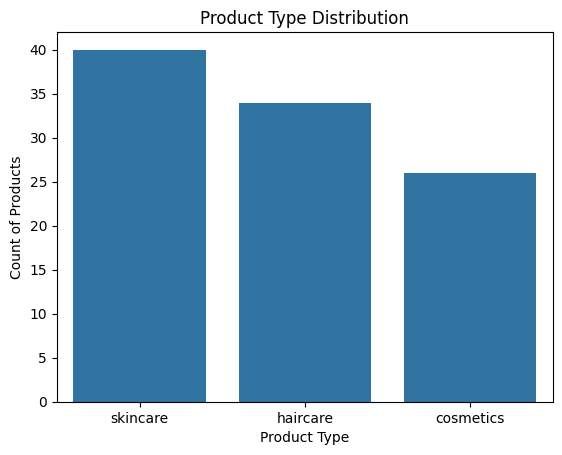

Average Product Price per type

 | Product type   |   Price |
|:---------------|--------:|
| cosmetics      | 57.3611 |
| skincare       | 47.2593 |
| haircare       | 46.0143 |


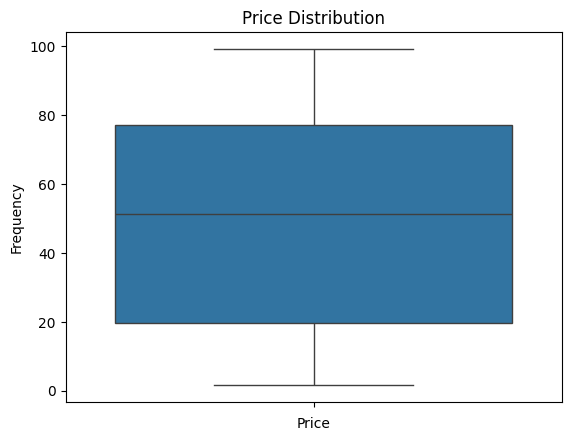

In [342]:

#Analysis of type of the Products
product_counts = products['Product type'].value_counts()
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.title("Product Type Distribution")
plt.xlabel("Product Type")
plt.ylabel("Count of Products")
plt.show()

#Price Analysis
mean_product_price_by_type = products.groupby('Product type')['Price'].mean().sort_values(ascending=False)
print("Average Product Price per type\n\n",mean_product_price_by_type.to_markdown(index=True))

#Price Distribution and identifying Outliers if any
sns.boxplot(products['Price'])
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


##### Inventory

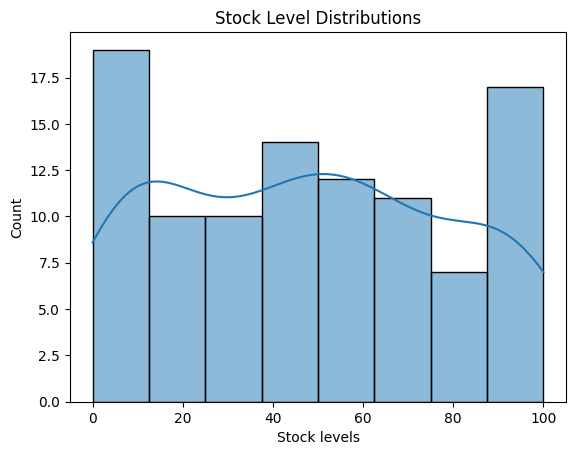

Stockouts by zero stock level:


 | SKU   |   Stock levels | Location   |   Availability |
|:------|---------------:|:-----------|---------------:|
| SKU68 |              0 | Bangalore  |             29 |

Number of Stockouts by unmet demand: 49


Stockouts:

 | SKU   |   Stock levels | Location   |   Availability |   Unmet Demand |
|:------|---------------:|:-----------|---------------:|---------------:|
| SKU1  |             53 | Mumbai     |             95 |             42 |
| SKU2  |              1 | Mumbai     |             34 |             33 |
| SKU3  |             23 | Kolkata    |             68 |             45 |
| SKU4  |              5 | Delhi      |             26 |             21 |
| SKU6  |             11 | Kolkata    |             48 |             37 |
| SKU8  |              5 | Mumbai     |             78 |             73 |
| SKU9  |             14 | Chennai    |             35 |             21 |
| SKU11 |             46 | Kolkata    |             95 |             49 |

In [343]:

#stock level distributions
sns.histplot(inventory['Stock levels'],kde=True)
plt.title('Stock Level Distributions')
plt.show()

#zero stock levels i.e. stockouts due to zero stock levels
print("Stockouts by zero stock level:\n\n\n",inventory[inventory['Stock levels']==0].to_markdown(index=False))

#Number of stockouts due to unmet demand
inventory['Unmet Demand']=inventory['Availability']-inventory['Stock levels']
stockouts_unmet_demand = inventory[inventory['Unmet Demand'] > 0]
print("\nNumber of Stockouts by unmet demand:",len(stockouts_unmet_demand))

#Total Stockouts
stockouts_combined = inventory[(inventory['Stock levels'] == 0) | (inventory['Unmet Demand'] > 0)]
print("\n\nStockouts:\n\n",stockouts_combined.to_markdown(index=False))




##### Revenue

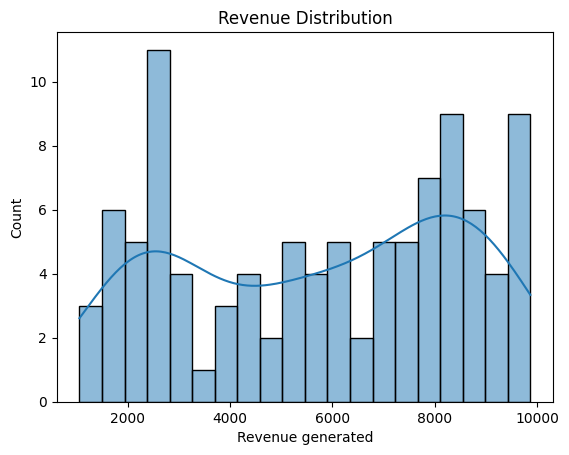

Top 10 SKUs by Sales:
 |   Number of products sold |
|--------------------------:|
|                       996 |
|                       987 |
|                       980 |
|                       963 |
|                       963 |
|                       960 |
|                       946 |
|                       933 |
|                       919 |
|                       916 |


In [344]:
# Revenue distribution
sns.histplot(sales['Revenue generated'], bins=20,kde=True)
plt.title('Revenue Distribution')
plt.show()

# Top-selling SKUs
top_skus = sales.groupby('SKU')['Number of products sold'].sum().sort_values(ascending=False).head(10)
print("Top 10 SKUs by Sales:\n", top_skus.to_markdown(index=False))


##### Shipping

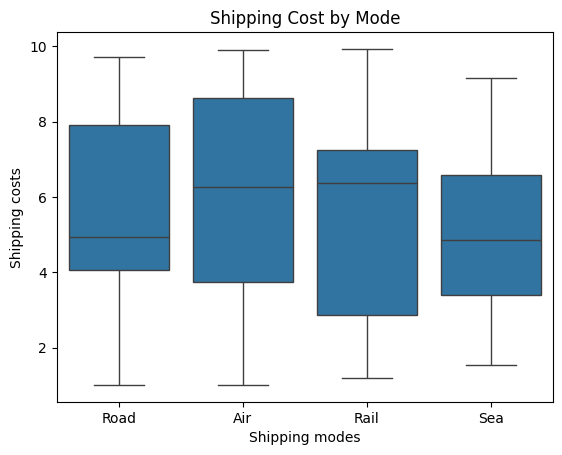

Avg Lead Time by Carrier:
 | Shipping carriers   |   Shipping times |
|:--------------------|-----------------:|
| Carrier A           |          6.14286 |
| Carrier B           |          5.30233 |
| Carrier C           |          6.03448 |


Text(0.5, 0, 'Days')

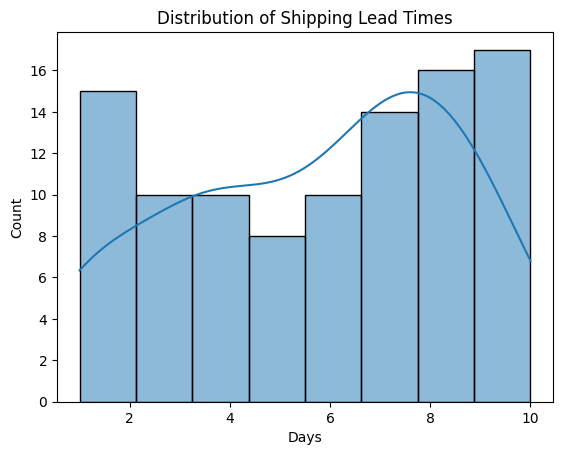

In [345]:
# Shipping cost by mode
sns.boxplot(x='Shipping modes', y='Shipping costs', data=shipping)
plt.title('Shipping Cost by Mode')
plt.show()

# Avg lead time by carrier
print("Avg Lead Time by Carrier:\n", shipping.groupby('Shipping carriers')['Shipping times'].mean().to_markdown(index=True))

#Distribution of Shipping Lead times
sns.histplot(shipping['Shipping times'],kde=True)
plt.title('Distribution of Shipping Lead Times')
plt.xlabel('Days')


##### Suppliers

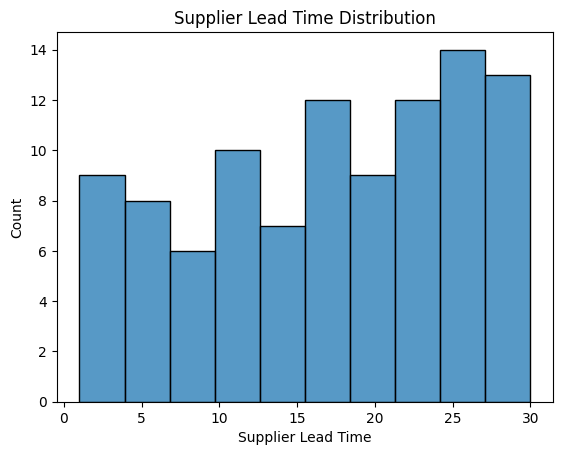

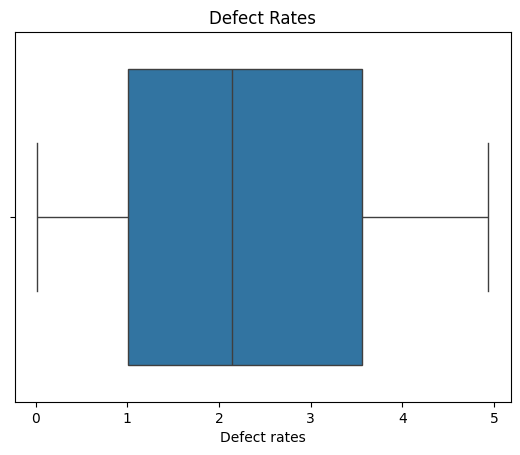

In [346]:
# Lead time distribution
sns.histplot(suppliers['Supplier Lead Time'], bins=10)
plt.title('Supplier Lead Time Distribution')
plt.show()

# Defect rate outliers
sns.boxplot(x=suppliers['Defect rates'])
plt.title('Defect Rates')
plt.show()


##### **Manufacturing**

Average Manufacturing Cost per location

 | Location   |   Manufacturing costs |
|:-----------|----------------------:|
| Mumbai     |               36.7309 |
| Kolkata    |               41.8631 |
| Delhi      |               48.88   |
| Chennai    |               51.145  |
| Bangalore  |               61.995  |


Distrubution of Manufacturing Cost per SKU



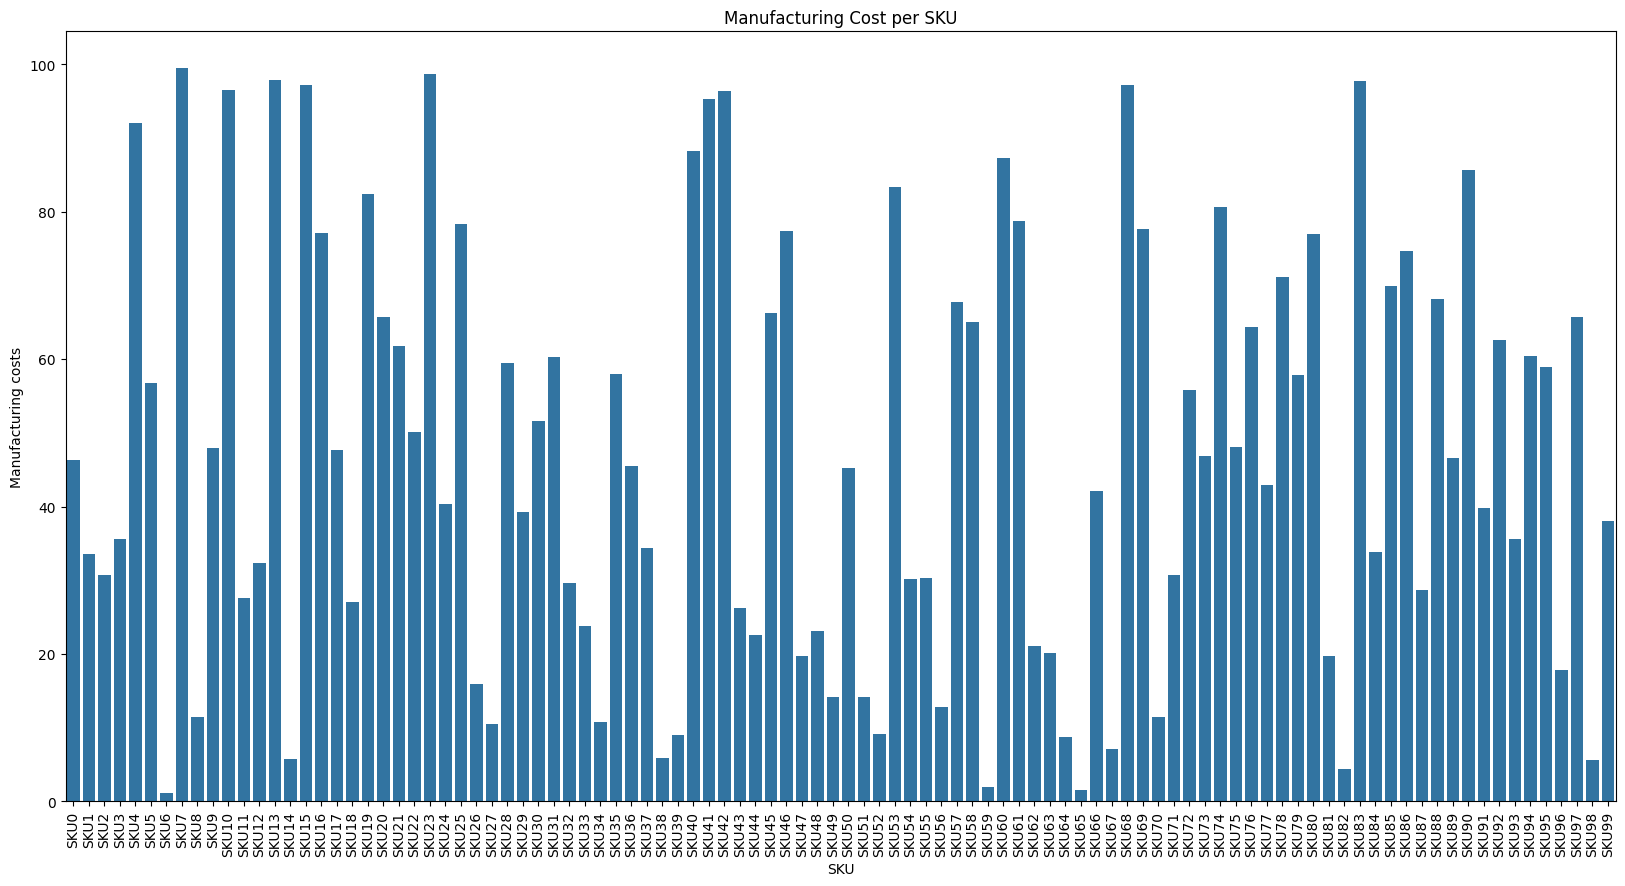



Pass/Fail Ratio



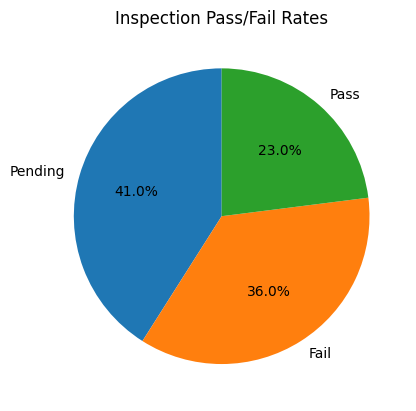

In [347]:
# Manufacturing cost per Location
mean_manf_cost_per_location=Total.groupby('Location')['Manufacturing costs'].mean().sort_index(ascending=False)
print("Average Manufacturing Cost per location\n\n",mean_manf_cost_per_location.to_markdown(index=True))

#Manufactruing Cost per SKU
print("\n\nDistrubution of Manufacturing Cost per SKU\n")
fig = plt.subplots(figsize=(20,10))
sns.barplot(data=Total, x='SKU', y='Manufacturing costs')
plt.title('Manufacturing Cost per SKU')
plt.xticks(rotation=90)
plt.show()

# Pass/Fail Ratio
print("\n\nPass/Fail Ratio\n")
inspect_results = manufacturing['Inspection results'].value_counts()
inspect_results.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Inspection Pass/Fail Rates')
plt.ylabel('')
plt.show()

### **Bivariate Analysis**

##### Cost vs Lead Time

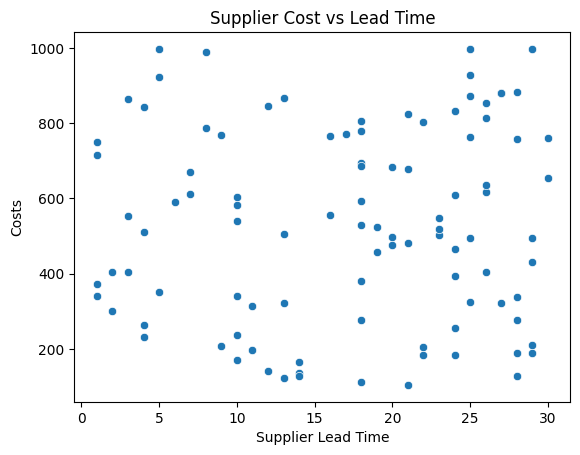

In [348]:
sns.scatterplot(data=suppliers,x='Supplier Lead Time',y='Costs')
plt.title("Supplier Cost vs Lead Time")
plt.show()

#### Cost vs Defect Rate

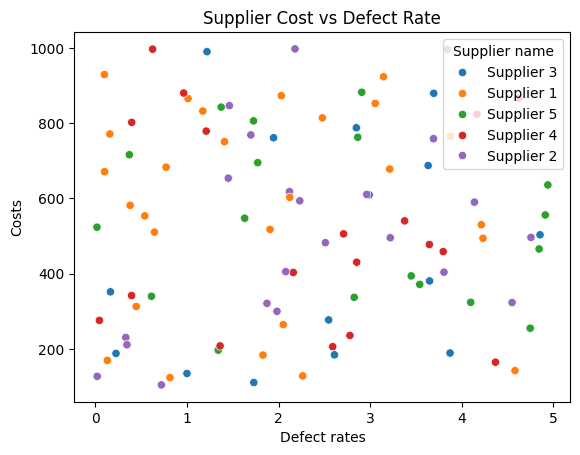

Average Defect Rate per Supplier

 | Supplier name   |   Defect rates |
|:----------------|---------------:|
| Supplier 5      |        2.66541 |
| Supplier 4      |        2.3374  |
| Supplier 3      |        2.46579 |
| Supplier 2      |        2.36275 |
| Supplier 1      |        1.80363 |


In [349]:
# Cost vs Defect Rate
sns.scatterplot(data=suppliers, x='Defect rates', y='Costs', hue='Supplier name')
plt.title('Supplier Cost vs Defect Rate')
plt.show()

defect_rate_per_supplier=suppliers.groupby('Supplier name')['Defect rates'].mean().sort_index(ascending=False)
print("Average Defect Rate per Supplier\n\n",defect_rate_per_supplier.to_markdown(index=True))

##### Shipping Costs vs Routes

Average Cost per route
|   Shipping costs |
|-----------------:|
|          5.90322 |
|          5.55199 |
|          5.3797  |


<Axes: xlabel='Routes', ylabel='Shipping costs'>

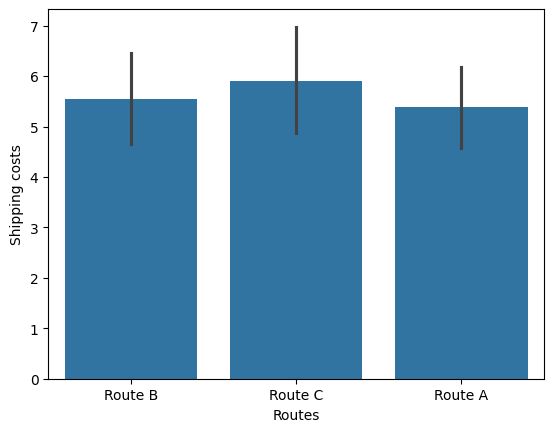

In [350]:
#avg shipping per route

avg_cost=shipping.groupby('Routes')['Shipping costs'].mean().sort_values(ascending=False)
print("Average Cost per route")
print(avg_cost.to_markdown(index=False))

sns.barplot(data=shipping,x='Routes',y="Shipping costs", estimator= np.mean)

### ****Top KPIs****

##### Top 10 SKUs by revenue

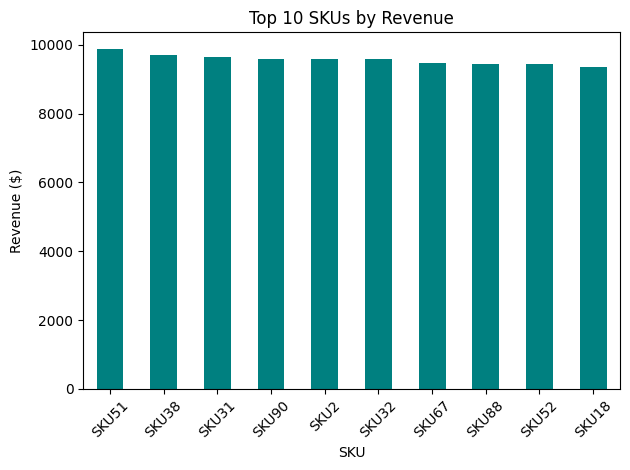

In [351]:
# Top 10 SKUs by revenue
sku_rev = sales.groupby('SKU')['Revenue generated'].sum().sort_values(ascending=False).head(10)
sku_rev.plot(kind='bar', color='teal')
plt.title('Top 10 SKUs by Revenue')
plt.xlabel('SKU')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Service Level : Service Level refers to the percentage of customer demand that is met without stockouts. It is a key performance indicator (KPI) used to measure how well a supply chain or inventory system satisfies customer needs on time and in full.**

In [352]:
#Service Level
on_time_deliveries = shipping[shipping['Shipping times'] <= shipping['Shipping times'].mean()]
service_level = len(on_time_deliveries) / len(shipping) * 100
print("Service Level: {:.2f}%".format(service_level))


Service Level: 43.00%


**Total Cost per Unit is the sum of all costs incurred to produce, store, and deliver one unit of a product. It’s a key metric in supply chain, manufacturing, and financial analysis to understand profitability and pricing.**




In [353]:
total_cost = shipping['Shipping costs'].sum() + inventory['Stock levels'].sum() * 0.5  # example holding cost
units_delivered = sales['Number of products sold'].sum()
cost_per_unit = total_cost / units_delivered
print("Cost per Unit: ${:.2f}".format(cost_per_unit))


Cost per Unit: $0.06


**Stockout Rate is a metric that measures how often inventory is unavailable when there is demand. It indicates the frequency or proportion of stockouts and is a critical KPI in supply chain and inventory management.**



Stockouts due to zero stock levels: 1
Stockouts due to unmet demand: 49
Total stockout events (combined): 49
Total unmet units across stockouts: 1858
Overall Stockout Rate: 49.00%

Stockouts by Product Type:
Product type
cosmetics    11
haircare     15
skincare     23
dtype: int64

Stockouts by Location:
Location
Bangalore    10
Chennai      13
Delhi         8
Kolkata       8
Mumbai       10
dtype: int64


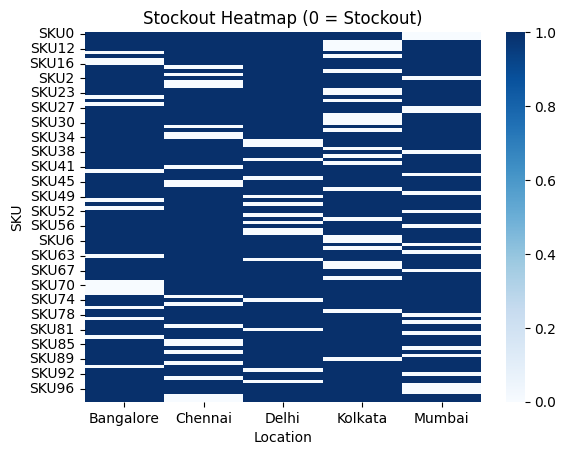

In [354]:
# Stockout rate (unique SKUs)

# Calculate stcokouts for unmet demand
inventory['Unmet Demand'] = inventory['Availability'] - inventory['Stock levels']

# Identify stockouts where stock is zero OR unmet demand is positive
stockouts_zero_stock = inventory[inventory['Stock levels'] == 0]
stockouts_unmet_demand = inventory[inventory['Unmet Demand'] > 0]

# Combine both conditions (union of both sets)
stockouts_combined = inventory[(inventory['Stock levels'] == 0) | (inventory['Unmet Demand'] > 0)]


# Metrics
num_zero_stock = len(stockouts_zero_stock)
num_unmet_demand = len(stockouts_unmet_demand)
num_combined_stockouts = len(stockouts_combined)
total_unmet_units = stockouts_combined['Unmet Demand'].clip(lower=0).sum()

print(f"Stockouts due to zero stock levels: {num_zero_stock}")
print(f"Stockouts due to unmet demand: {num_unmet_demand}")
print(f"Total stockout events (combined): {num_combined_stockouts}")
print(f"Total unmet units across stockouts: {total_unmet_units}")

# Stockout rate relative to total inventory rows
stockout_rate = (num_combined_stockouts / len(inventory)) * 100
print(f"Overall Stockout Rate: {stockout_rate:.2f}%")

# Breakdown by Product type and Location
print("\nStockouts by Product Type:")
print(stockouts_combined.groupby(Total['Product type']).size())

print("\nStockouts by Location:")
print(stockouts_combined.groupby('Location').size())
# Stockouts heatmap
stockout_hmap = inventory.pivot_table(values='Stock levels', index='SKU', columns='Location', fill_value=0)
sns.heatmap(stockout_hmap == 0, cmap='Blues')
plt.title('Stockout Heatmap (0 = Stockout)')
plt.show()


**Inventory Turnover = Cost of Goods Sold (COGS) / Average Inventory**


Inventory Turnover in dollars: 3156.722124391176


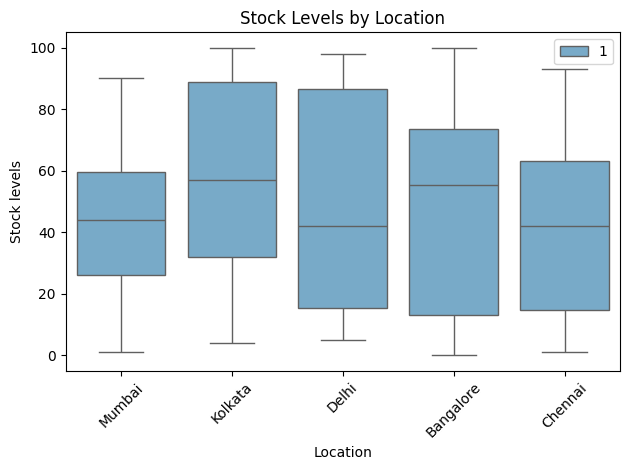

In [355]:
unit_cost=(Total["Manufacturing costs"]+Total['Costs']+Total['Shipping costs'])/(Total['Number of products sold'])
avg_inventory=(Total['Stock levels']*unit_cost).mean()
cogs=Total['Revenue generated'].sum()*0.7
invt_tnr=cogs/avg_inventory
print("Inventory Turnover in dollars:",invt_tnr)

# Stock levels across locations
sns.boxplot(data=inventory, x='Location', y='Stock levels', palette='Blues',hue=1)
plt.title('Stock Levels by Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


****Supplier Lead Time is the amount of time taken from placing an order with a supplier to receiving the goods. It measures how long it takes for the supplier to fulfill an order.****




Average Supplier lead time :  17.08
| Supplier Name   |   Supplier Lead Time |
|:----------------|---------------------:|
| Supplier 1      |              14.7778 |
| Supplier 2      |              18.5455 |
| Supplier 3      |              20.1333 |
| Supplier 4      |              15.2222 |
| Supplier 5      |              18.0556 |


<Axes: xlabel='Supplier name', ylabel='Supplier Lead Time'>

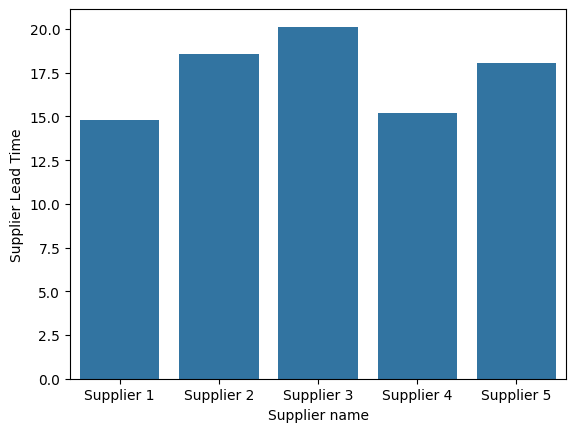

In [357]:
avg_supplier_lead_time = suppliers.groupby('Supplier name')['Supplier Lead Time'].mean().reset_index()
total_avg_supplier_lead_time = suppliers['Supplier Lead Time'].mean()
df=pd.DataFrame(avg_supplier_lead_time)
avg_supplier_lead_time.columns = ['Supplier Name', 'Supplier Lead Time']
print("\nAverage Supplier lead time : ",total_avg_supplier_lead_time)
print(avg_supplier_lead_time.to_markdown(index=False))

sns.barplot(data=df,x="Supplier name", y="Supplier Lead Time")




****Average Shipping Cost per Mode measures the mean cost of shipping goods using each transportation mode (e.g., air, sea, truck, rail).****



| Shipping Mode   |   Average Shipping Cost |
|:----------------|------------------------:|
| Air             |                    6.02 |
| Rail            |                    5.47 |
| Road            |                    5.54 |
| Sea             |                    4.97 |


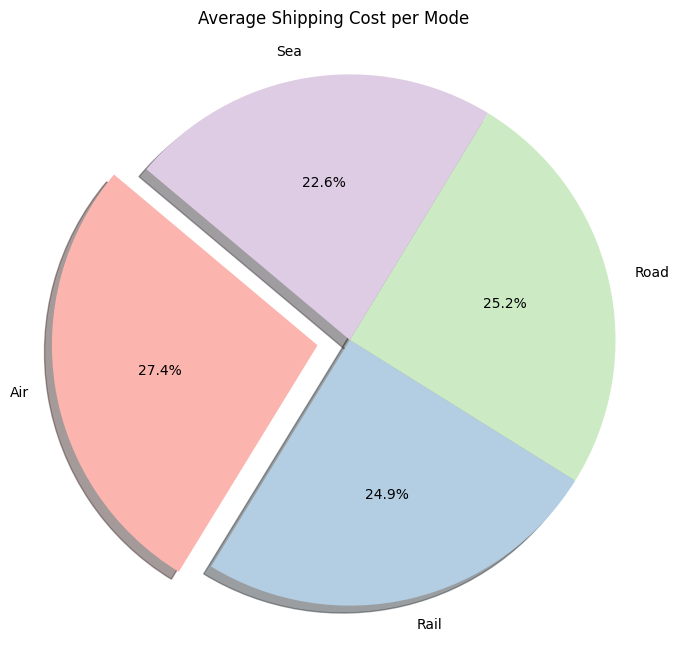

In [ ]:
avg_shipping_cost_mode = shipping.groupby('Shipping modes')['Shipping costs'].mean().reset_index()
avg_shipping_cost_mode.columns = ['Shipping Mode', 'Average Shipping Cost']

avg_shipping_cost_mode['Average Shipping Cost'] = avg_shipping_cost_mode['Average Shipping Cost'].round(2)

avg_shipping_cost_mode.style.set_caption("Average Shipping Cost per Mode").format({'Average Shipping Cost': '${:,.2f}'})

print(avg_shipping_cost_mode.to_markdown(index=False))
sizes = avg_shipping_cost_mode['Average Shipping Cost']
labels = avg_shipping_cost_mode['Shipping Mode']
max_index = np.argmax(sizes)

explode = [0] * len(sizes)
explode[max_index] = 0.1234

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode, shadow=True, colors=plt.cm.Pastel1.colors)
plt.title("Average Shipping Cost per Mode")
plt.axis('equal')  # make pie circular
plt.show()

#### Summary Table

In [ ]:
sku_rev = sales.groupby('SKU')['Revenue generated'].sum()

summary = {
    "Total Units Sold": sales["Number of products sold"].sum(),
    "Total Revenue ($)": sales["Revenue generated"].sum(),
    "Avg Service Level (%)": service_level,
    "Stockout Rate (%)": stockout_rate,
    "Avg Cost per Unit ($)": cost_per_unit,
    "Inventory Turnover($)": invt_tnr,
    "Average Supplier lead time(days)" :total_avg_supplier_lead_time,
    "Top SKU": sku_rev.idxmax(),
    
}

kpi_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])
kpi_df.index.name = 'KPIs'
kpi_df['Value'] = kpi_df['Value'].apply(
    lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x
)
print(kpi_df.to_markdown())

print("\n\n\nthis kpi is the last and one of the most important ones i.e. Average Shipping Cost per Mode\n")
print(avg_shipping_cost_mode.to_markdown(index=False))

| KPIs                             | Value      |
|:---------------------------------|:-----------|
| Total Units Sold                 | 46099      |
| Total Revenue ($)                | 577,604.82 |
| Avg Service Level (%)            | 43.00      |
| Stockout Rate (%)                | 49.00      |
| Avg Cost per Unit ($)            | 0.06       |
| Inventory Turnover($)            | 3,156.72   |
| Average Supplier lead time(days) | 17.08      |
| Top SKU                          | SKU51      |



this kpi is the last and one of the most important ones i.e. Average Shipping Cost per Mode

| Shipping Mode   |   Average Shipping Cost |
|:----------------|------------------------:|
| Air             |                    6.02 |
| Rail            |                    5.47 |
| Road            |                    5.54 |
| Sea             |                    4.97 |


### Why these KPIs?

| **KPI**                        | **Why Include in EDA?**                                               |
| ------------------------------ | --------------------------------------------------------------------- |
| **Total Units Sold**           | Indicates overall demand and sales volume across the supply chain.    |
| **Total Revenue (\$)**         | Measures business performance; ties into cost and profitability.      |
| **Avg Service Level (%)**      | Shows delivery reliability; essential for customer satisfaction.      |
| **Stockout Rate (%)**          | Highlights supply-demand mismatches and fulfillment issues.           |
| **Avg Cost per Unit (\$)**     | Helps evaluate cost efficiency in production and logistics.           |
| **Inventory Turnover (\$)**    | Flags excess, obsolete, or slow-moving inventory.                     |
| **Average Supplier Lead Time** | Important for modeling delays and building resilience to disruptions. |
| **Top SKU**                    | Identifies best-selling/high-revenue products to focus on.            |
|**Average Shipping Cost per Mode**	 |  Crucial for identifying the most cost-effective transportation methods; directly impacts logistics cost optimization.|


**The numeric columns are only eligible for correlation and pair plots so we will try to get a summarised view of how the numeric factors interact with each other.**

# Correlation Matrix

<Axes: >

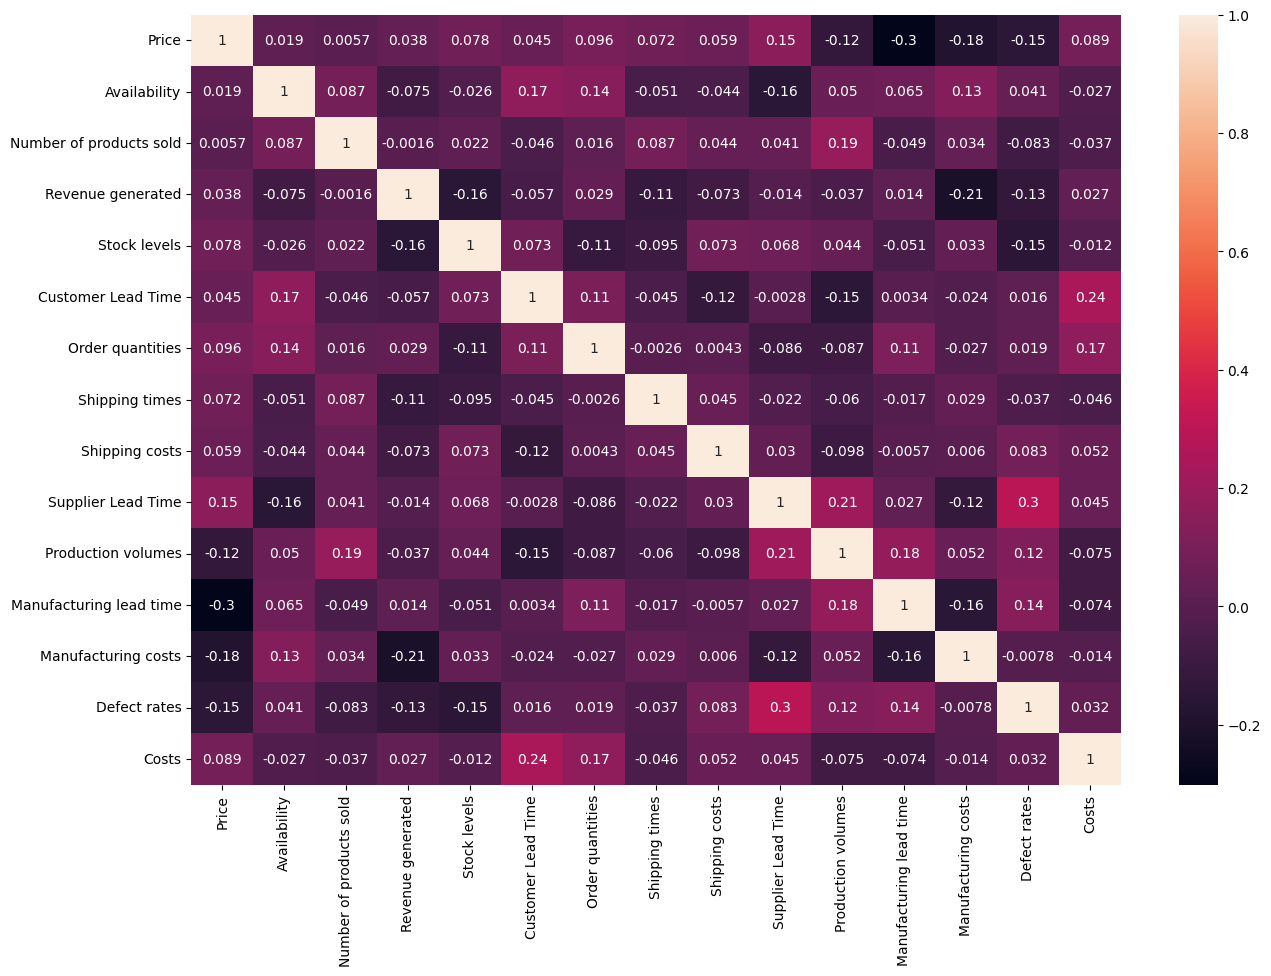

In [ ]:
Corr_eligible_df = Total.select_dtypes(include=['number'])
Corr_eligible_df.corr()

fig = plt.subplots(figsize=(15,10))
sns.heatmap(Corr_eligible_df.corr(),annot=True)


**Here, we will combine the columns in the most insightful manner to understand their correlation and make pairplots for each of the dataframe we will be creating.**

#### Pairplots for most important columns

Pairplot for Sales & Inventory Metrics with columns: ['Price', 'Number of products sold', 'Revenue generated', 'Stock levels', 'Order quantities', 'Availability']


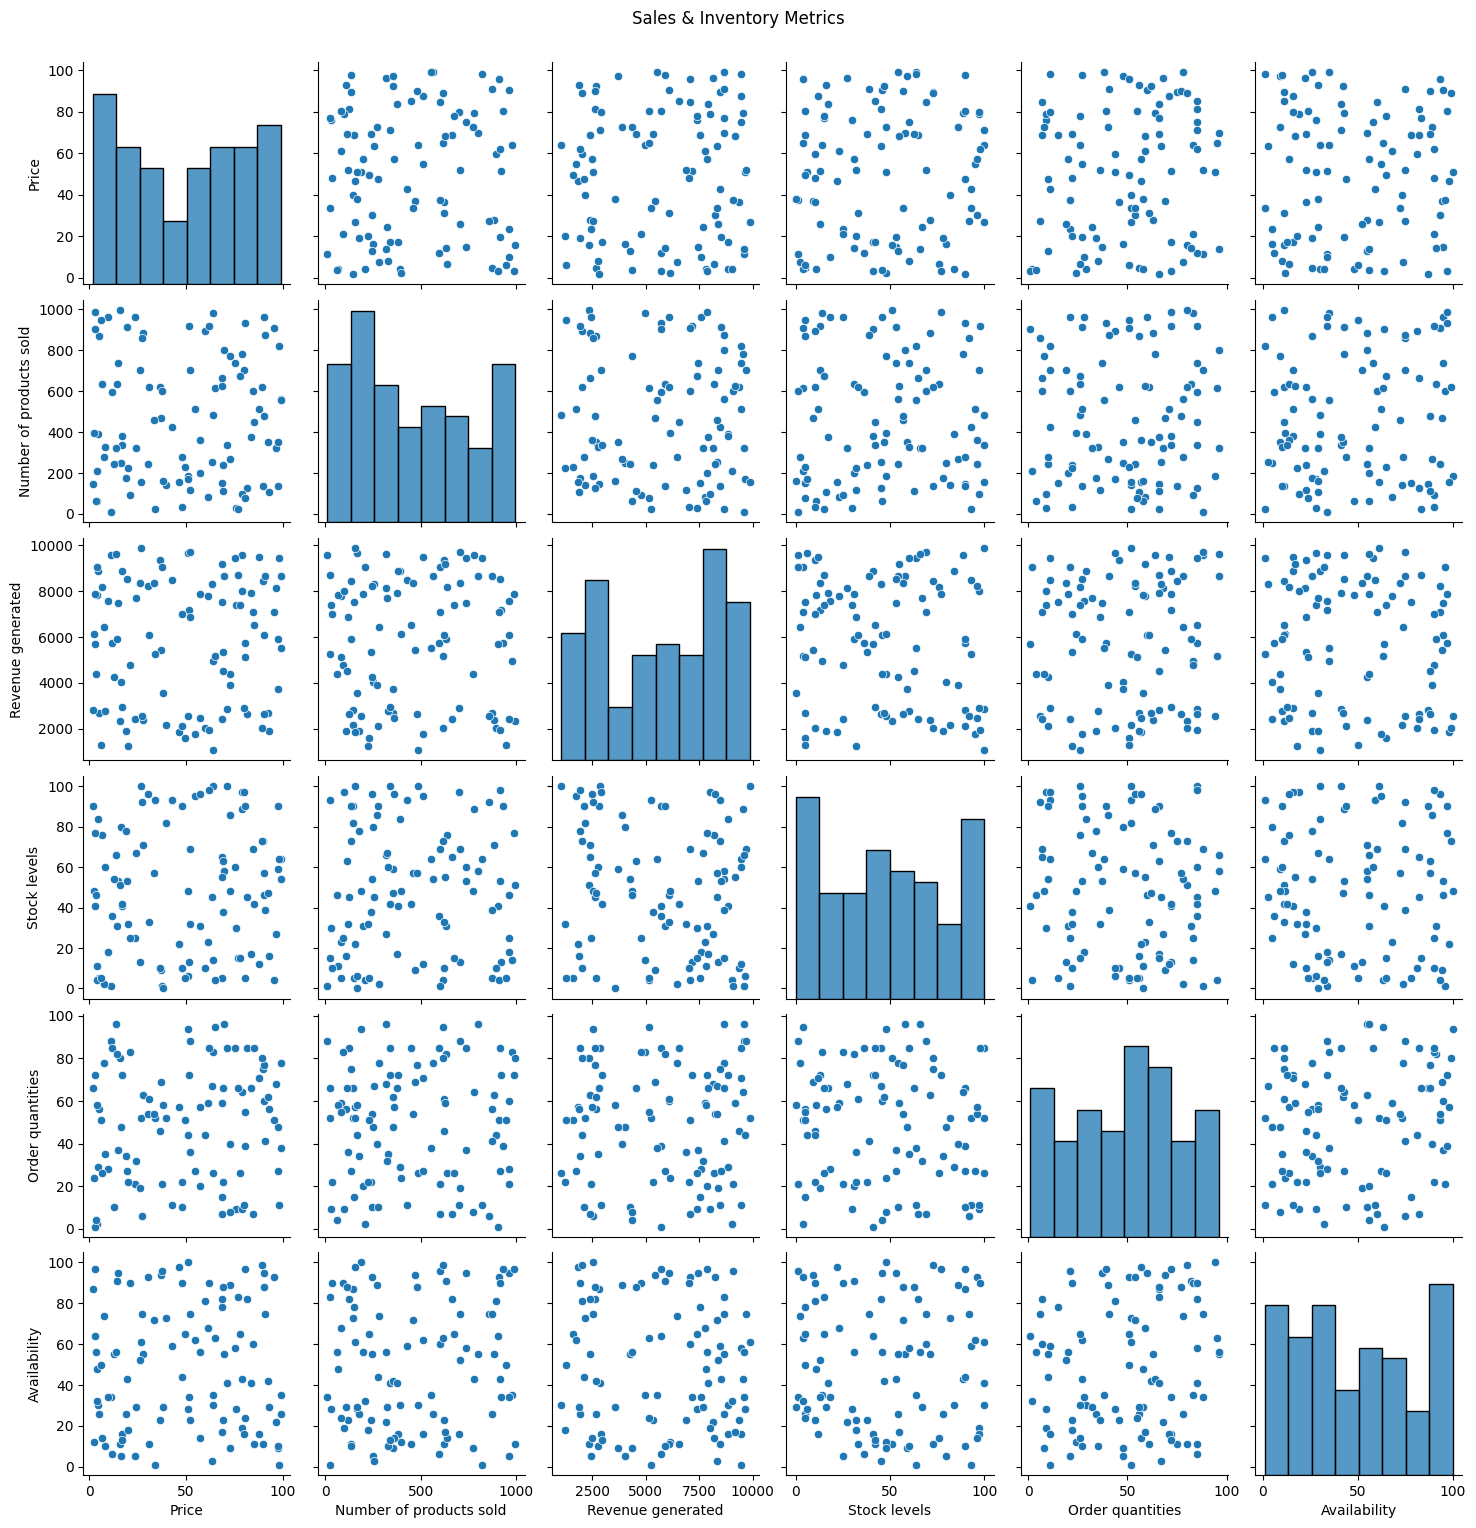

Pairplot for Supply Chain Timings with columns: ['Manufacturing lead time', 'Shipping times']


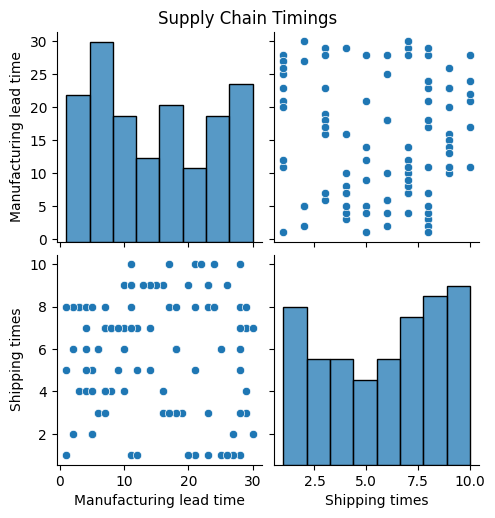

Pairplot for Costs & Production with columns: ['Price', 'Shipping costs', 'Manufacturing costs', 'Costs', 'Production volumes']


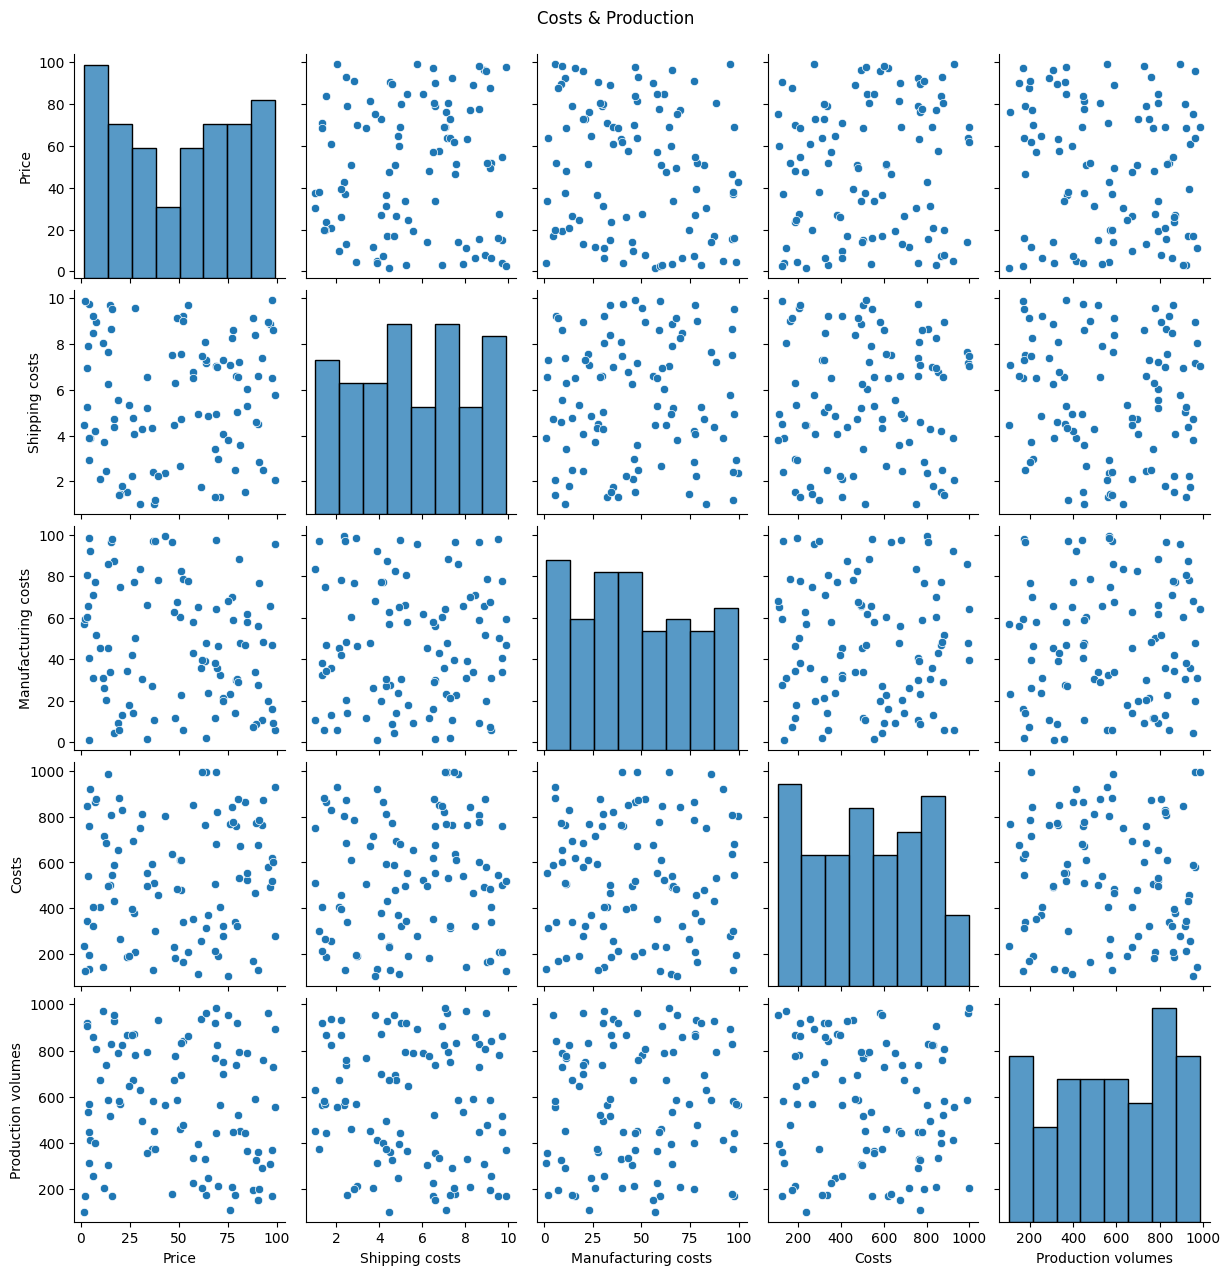

Pairplot for Quality & Inspection with columns: ['Inspection results', 'Defect rates']


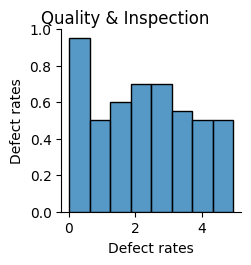

In [ ]:
# we should define column groups based on whichever type of data is there in the df

sales_inventory_cols = [
    'Price', 
    'Number of products sold', 
    'Revenue generated', 
    'Stock levels', 
    'Order quantities', 
    'Availability'
]

supply_chain_timings_cols = [
    'Lead times', 
    'Manufacturing lead time', 
    'Shipping times'
]

costs_production_cols = [
    'Price', 
    'Shipping costs', 
    'Manufacturing costs', 
    'Costs', 
    'Production volumes'
]

quality_inspection_cols = [
    'Inspection results', 
    'Defect rates'
]

def create_df(Dataframe1, cols):
    existing_cols = [col for col in cols if col in Dataframe1.columns]
    return Dataframe1[existing_cols].copy()

df_sales_inventory = create_df(Total, sales_inventory_cols)
df_supply_chain_timings = create_df(Total, supply_chain_timings_cols)
df_costs_production = create_df(Total, costs_production_cols)
df_quality_inspection = create_df(Total, quality_inspection_cols)

groups = {
    "Sales & Inventory Metrics": sales_inventory_cols,
    "Supply Chain Timings": supply_chain_timings_cols,
    "Costs & Production": costs_production_cols,
    "Quality & Inspection": quality_inspection_cols,
}

for group_name, cols in groups.items():
    df_group = create_df(Total, cols).dropna()
    print(f"Pairplot for {group_name} with columns: {list(df_group.columns)}")
    sns.pairplot(df_group)
    plt.suptitle(group_name, y=1.02)
    plt.show()

##### Correlation matrices for better understanding by dividing the data frames into parts which can be used together

Correlation Matrix for Sales & Inventory Metrics with columns: ['Price', 'Number of products sold', 'Revenue generated', 'Stock levels', 'Order quantities', 'Availability']


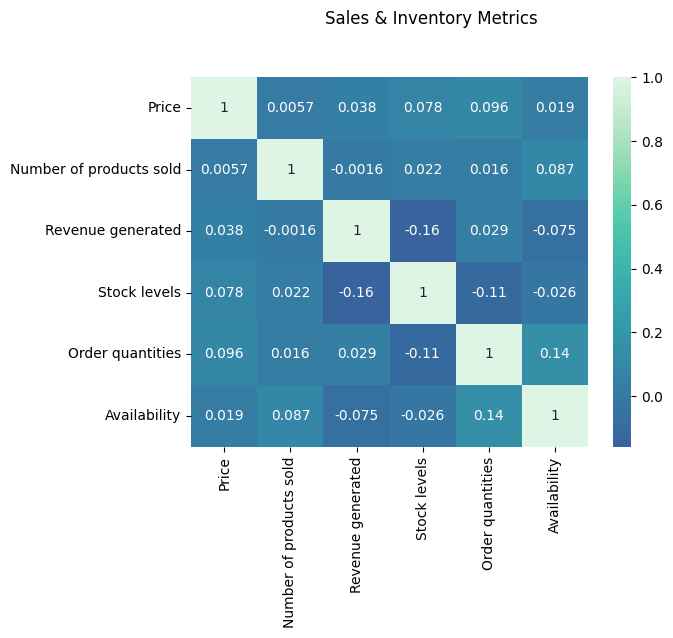

Correlation Matrix for Supply Chain Timings with columns: ['Manufacturing lead time', 'Shipping times']


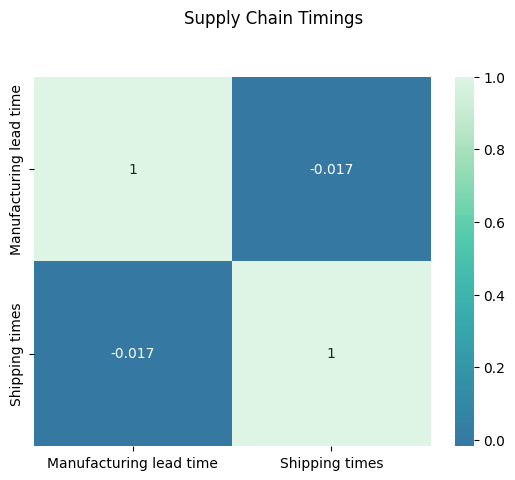

Correlation Matrix for Costs & Production with columns: ['Price', 'Shipping costs', 'Manufacturing costs', 'Costs', 'Production volumes']


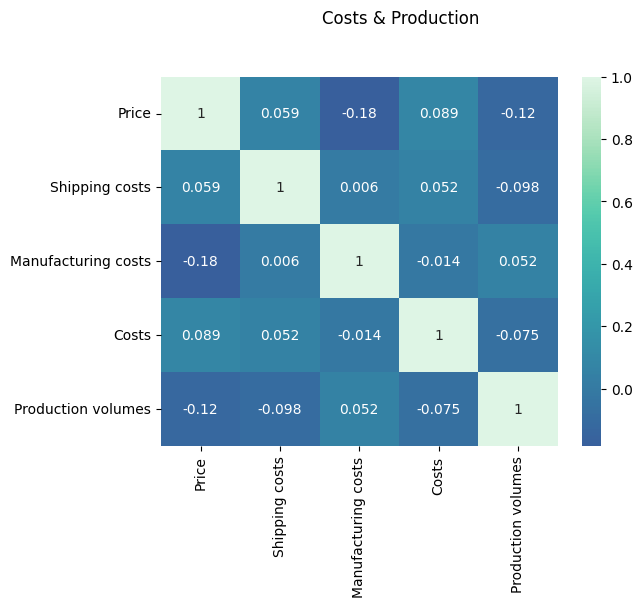

Correlation matrix is not possible for non-numeric or insufficient columns in Quality & Inspection


In [ ]:
 #Correlation matrices for all the newly created dataframes
for group_name, cols in groups.items():
    df_group = create_df(Total, cols).dropna()
    
    # Select only numeric columns from df_group
    numeric_df = df_group.select_dtypes(include=['number'])
    
    if numeric_df.shape[1] < 2:
        print(f"Correlation matrix is not possible for non-numeric or insufficient columns in {group_name}")
        continue
    
    print(f"Correlation Matrix for {group_name} with columns: {list(numeric_df.columns)}")
    sns.heatmap(numeric_df.corr(), annot=True, cmap='mako', center=0)
    plt.suptitle(group_name, y=1.02)
    plt.show()
